In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Define the network architecture
* `input_img` is our input image
* `encoded` is the encoded representation of the input
* `decoded` is the lossy reconstruction of the input
* The `autoencoder` model maps an input to its reconstruction

In [ ]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = keras.Input(shape=(784,))

#Add the regularization
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

Create separate `encoder` and `decoder` models for further use.

In [ ]:
encoder = keras.Model(input_img, encoded)

In [ ]:
encoded_input = keras.Input(shape=(encoding_dim,)) # encoded (32-dimensional) input
decoder_layer = autoencoder.layers[-1] # the last layer from our autoencoder
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Compile the autoencoder for creating the computational graph. For this example we will use the [Adam](https://keras.io/api/optimizers/adam/) optimizer and the [binary_crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) loss function;

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Load and pre-process the data

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Train the model for 50 epochs

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0)

After training the model, encode and decode some digits.
Note that we take them from the *test* set

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Now, visualize the result

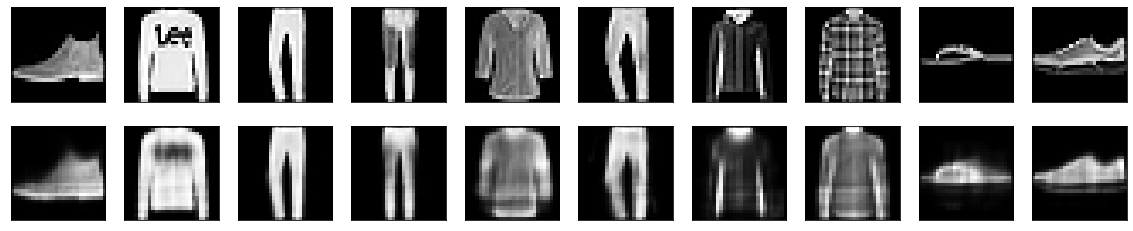

In [ ]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We will use the t-sne alogrithm for dimensionality reduction and check how our 
latent space looks like.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
encoded_imgs_embedded = TSNE(n_components=2).fit_transform(encoded_imgs)

In [ ]:
encoded_imgs_embedded.shape

(10000, 2)

Do the plotting

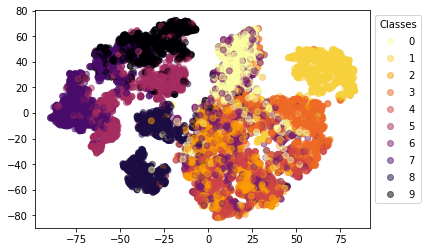

In [ ]:
colors = y_test
fig, ax = plt.subplots()
scatter = ax.scatter(encoded_imgs_embedded[:,0], 
            encoded_imgs_embedded[:,1], 
            c=colors,  cmap=plt.cm.inferno_r, alpha=0.5)
ax.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1,1))
plt.show()

For reference: [Fashion MNIST dataset](https://keras.io/api/datasets/fashion_mnist/)

### Exercises

1. Increase the Latent Space size and see if that changes the performance of your model.
1. Build and compare classifiers for the encoded latent space and the normal data. Try a [few approaches](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) here.
1. Try to improve the performance by defining deeper autoencoders.
1. How about using Convolutions? Just remember to user some _Pooling_ for shrinking the size of the layers and _Upscaling_ for increasing their sizes.